<a href="https://colab.research.google.com/github/giacomobinco/FDS-Final-Project/blob/main/EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team information

Member 1: Bincoletto Giacomo (2253342 - bincoletto.2253342@studenti.uniroma1.it)

Member 2: Bireda Hermella Berhanu (2262768 - bireda.2262768@studenti.uniroma1.it)

Mmeber 3: Cuomo Ferdinando (2236364 - cuomo.2236364@studenti.uniroma1.it)

# Loading the necessary libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import zipfile
import os
from tqdm import tqdm
import shutil
import gc

import random
import warnings

from google.colab import files
from google.colab import drive

from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
from torchvision import datasets, transforms
from torch.nn.functional import softmax
import torchvision.models as models # to retrieve the "EfficientNet" family of models
from torch.optim.lr_scheduler import CosineAnnealingLR

# Settings

In [2]:
# Checking if the GPU is selected as hardware accelerator

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [3]:
# Utility function to controll for reproducibility

def set_seed(seed: int):

    # Python
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Setting a deterministic behaviour
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Setting the reproducibility of the "DataLoader" objects
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Loading the data

The folder in which the 8000 Mel-spectrograms were saved has been loaded in Google Drive

In [4]:
# Connecting Google Drive to the present notebook

drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Mel-spectrograms

In [5]:
# Load all the Mel-spectrograms generated from the "FMA_small" dataset
# [ !! It takes about 3 minutes !! ]

# Retrieving the folder's path
drive_folder = r"/content/drive/MyDrive/fma_spectrograms"

# Generating the output's folder
output_directory = "fma_spectrograms_organized"
os.makedirs(output_directory, exist_ok = True)

# Copying all the images (png files) in the output folder
for root, dirs, files in os.walk(drive_folder):
    for file in files:
        if file.lower().endswith(".png"):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(output_directory, file)
            shutil.copy(src_path, dst_path)

In [6]:
# Load the metadata, also saved in Google Drive, on the audio tracks (essentialy track id and musical genre)

tracks = pd.read_csv(r"/content/drive/MyDrive/tracks.csv", index_col = 0, header = [0,1])

In [7]:
# "fma_spectrograms_organized" is the folder created in the previous part of code and, as the name suggests,
# contains all the Mel-spectrograms in a structured way. However, the dataset will be saved in the following folder:
dataset_directory = "dataset"
os.makedirs(dataset_directory, exist_ok = True)

# Counters
copied = 0
skipped = 0

# For every file (spectrogram) saved in "fma_spectrograms_organized" ...
for fname in os.listdir(output_directory):

    # ... consider only the .png files (there shouldn't be any others though)
    if not fname.lower().endswith(".png"):
        continue

    # Get the audio track ID from the file name
    # (according to the method used to generate the spectrograms in the first place)
    track_id_str = fname.split("_")[0]

    # Convert the file name (a sequence of numbers) in a "int" object
    try:
        track_id = int(track_id_str)

    # If the conversion fails, the file is skipped
    except:
        skipped += 1
        continue

    # If the audio track ID doesn't exist in the audio tracks list (file "tracks.csv"), the file is skipped
    if track_id not in tracks.index:
        skipped += 1
        continue

    # From said csv file, collect the audio track's main genre
    genre = tracks.loc[track_id, ('track','genre_top')]

    # At this point, after getting every spectograms' genre, the idea is to save them in the folder corresponding
    # indeed to their genre (doing so allows to create balanced training and test sets)

    # Create the genre folder (within the "dataset" folder)
    genre_directory = os.path.join(dataset_directory, genre)
    os.makedirs(genre_directory, exist_ok = True)

    # Copy the spectrogram in the corresponding genre folder
    shutil.copy(os.path.join(output_directory, fname), os.path.join(genre_directory, fname))
    copied += 1

# Visual check
print(f"✅ {copied} files has been copied in the genres' sub-folders")
if skipped > 0:
  print(f"\n⚠️ {skipped} files with no correspondece has been found")

✅ 7997 files has been copied in the genres' sub-folders


## Splitting the data

In [8]:
# Using the current files' structure (organized in sub-folders per genre), two sets are defined:
# - the training test will be used to train the model, evaluate each execution and consequently optimize it
# - the test set will be used to compute the final evaluation of the model

# Since the dataset is almost perfectly balanced, the same structure is kept in both sets:
# considering 8000 images (1000 per genre), the training set contains 80% of them (6400 images, 800 per genre),
# while the test set has the remaing 20% (1600 images, 200 per genre)

# Output directories, in other words where the images will be copied from "dataset"
TRAIN_DIRECTORY = "/content/dataset_train"
TEST_DIRECTORY  = "/content/dataset_test"
os.makedirs(TRAIN_DIRECTORY, exist_ok = True)
os.makedirs(TEST_DIRECTORY, exist_ok = True)

# 1. Loading the images (spectrograms) and the labels (genres)

file_paths = [] # it will contain all the images
labels = []     # it will contain the corresponding labels

genres = sorted(os.listdir(dataset_directory))

for genre in genres:

    genre_dir = os.path.join(dataset_directory, genre)
    images = os.listdir(genre_dir) # all the images contained in a specific sub-folder (the one of the currente iteration)

    for img in images:

        file_paths.append(os.path.join(genre_dir, img)) # add the image to the container
        labels.append(genre)                            # add the corresponding genre to the container

file_paths = np.array(file_paths)
labels = np.array(labels)

# 2. Creating the split with "StratifiedShuffleSplit()", which automatically keeps the dataset balanced

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.20, random_state = 42)

for train_idx, test_idx in splitter.split(file_paths, labels):

    train_files = file_paths[train_idx] # spectrograms of the trainig set
    train_labels = labels[train_idx]    # genres of these spectrograms (training)
    test_files  = file_paths[test_idx]  # spectrograms of the test set
    test_labels = labels[test_idx]      # genres of these spectrograms (test)

# 3. Copying the files in the corresponding folders (created at the beginning of this cell)

def copy_files(files, labels, destination_root):
    # Utility function to use to execute this last task
    for file, label in zip(files, labels):
        dest_dir = os.path.join(destination_root, label) # selecting the correct folder
        os.makedirs(dest_dir, exist_ok = True)           # checking if it exits
        shutil.copy(file, dest_dir)                      # copying the image

copy_files(train_files, train_labels, TRAIN_DIRECTORY)
copy_files(test_files, test_labels, TEST_DIRECTORY)

## Processing the data

In [9]:
# Ignoring the normalization process temporarily in order to compute
# the mean and standard deviation of the training set

transform_no_norm = transforms.Compose([transforms.ToTensor()])
dataset_no_norm = datasets.ImageFolder(TRAIN_DIRECTORY, transform = transform_no_norm)

loader = DataLoader(dataset_no_norm, batch_size = 64, shuffle = False, num_workers = 2)

train_mean = 0.0
train_std = 0.0
train_total_images = 0

for images, _ in loader:

    # Structure of the images' shape: (batch, channels, height, width)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)
    train_total_images += batch_samples

train_mean /= train_total_images
train_std /= train_total_images

print("Mean (per channel) =", train_mean)
print("Standard Deviation (per channel) =", train_std)

Mean (per channel) = tensor([0.6547, 0.2471, 0.2830])
Standard Deviation (per channel) = tensor([0.2269, 0.1692, 0.1224])


In [10]:
# Data Augmentation

# Define utility functions to apply Data Augmentation to the Mel-spectrograms dataset, through "SpecAugment"
# (to insert inside the transformer, "transforms.Compose()") and "SpecMix" (directly in the training loop)

# 1. SpecAugment

class SpecAugment:

    # Implements SpecAugment for Mel-spectrograms by applying random frequency masking and time masking

    def __init__(self, time_mask_param = 25, freq_mask_param = 15, n_time_masks = 2, n_freq_masks = 2):

        self.tp = time_mask_param
        self.fp = freq_mask_param
        self.nt = n_time_masks
        self.nf = n_freq_masks

        # Parameters
        # - "time_mask_param": maximum width of the time mask
        # - "freq_mask_param": maximum width of the frequency mask
        # - "n_time_masks": number of time masks to apply
        # - "n_freq_masks": number of frequency masks to apply

    def __call__(self, spec):

        _, H, W = spec.shape
        spec = spec.clone()

        # Apply frequency masking
        for _ in range(self.nf):
            # Random mask width (frequency axis)
            f = random.randrange(0, self.fp)
            # Random starting frequency bin
            f0 = random.randrange(0, max(1, H-f))
            # Zero out the selected frequency band
            spec[:, f0:f0+f, :] = 0

        # Apply time masking
        for _ in range(self.nt):
            # Random mask width (time axis)
            t = random.randrange(0, self.tp)
            # Random starting time frame
            t0 = random.randrange(0, max(1, W-t))
            # Zero out the selected time segment
            spec[:, :, t0:t0+t] = 0

        return spec

# 2. SpecMix

def specmix(images, labels, alpha = 1.0):

    """
    Implements SpecMix, an adaptation of MixUp/CutMix for spectrograms

    Parameters
    - "images": batch of spectrograms (batch, channel, frequency, time)
    - "labels": corresponding labels
    - "alpha": parameter of the Beta distribution

    Outputs
    - "mixed_images": augmented spectrogram batch
    - "labels_a": original labels
    - "labels_b": permuted labels
    - "lam": mixing coefficient
    """

    # Extract batch size and spectrogram dimensions
    B, C, F, T = images.size()
    device = images.device

    # Sample lambda from a Beta distribution
    lam = torch.distributions.Beta(alpha, alpha).sample().item()

    # Random batch permutation
    index = torch.randperm(B).to(device)

    # Masks dimension (frequency + time)
    cut_f = int(F * torch.sqrt(torch.tensor(1. - lam)))
    cut_t = int(T * torch.sqrt(torch.tensor(1. - lam)))

    # Mask center
    f0 = torch.randint(0, F - cut_f + 1, (1,)).item()
    t0 = torch.randint(0, T - cut_t + 1, (1,)).item()

    # Apply SpecMix by replacing a rectangular region with the same region from another sample in the batch
    mixed_images = images.clone()
    mixed_images[:, :, f0: f0+cut_f, t0: t0+cut_t] = \
        images[index, :, f0: f0+cut_f, t0: t0+cut_t]

    # Update the value of lambda
    lam = 1 - (cut_f * cut_t) / (F * T)

    labels_a = labels
    labels_b = labels[index]

    return mixed_images, labels_a, labels_b, lam

## Final Dataset

In [11]:
# Creating a dataset of images specifically for PyTorch, and loading it into a DataLoader object

training_transform = transforms.Compose([
    # Randomly crop and resize the image to 224*224
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    # Apply Data Augmentation
    SpecAugment(),
    # Normalize the image using the training set mean and standard deviation
    transforms.Normalize(train_mean, train_std)])

test_transform = transforms.Compose([
    # Resize the image to a fixed spatial resolution (224*224)
    # (no random operations are applied to ensure determinism)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # SpecAugment()
    # --> It's wrong to apply Data Augmentation to the test set, it artificially increases the final accuracy
    transforms.Normalize(train_mean, train_std)])
    # To avoid data leakage and improve generability, it's better to use the same "normalization measures"

train_dataset = datasets.ImageFolder(TRAIN_DIRECTORY, transform = training_transform)
test_dataset = datasets.ImageFolder(TEST_DIRECTORY, transform = test_transform)

# Visual check
print("Training dataset -------------------------")
print("\nNumber of categories found:", len(train_dataset.classes)) # they should be 8
print("Total number of images uploaded:", len(train_dataset))      # they should be 6397
print("\nTest dataset -----------------------------")
print("\nNumber of categories found:", len(test_dataset.classes)) # they should be 8
print("Total number of images uploaded:", len(test_dataset))      # they should be 1600

Training dataset -------------------------

Number of categories found: 8
Total number of images uploaded: 6397

Test dataset -----------------------------

Number of categories found: 8
Total number of images uploaded: 1600


# Training and evaluation

## Initialization

In [12]:
# Utility function to implement Early Stopping in the training loop

class EarlyStopping:

    def __init__(self, patience = 5, min_delta = 0.0, verbose = False, path = 'checkpoint.pt'):

        """
        Parameters
        - "patience": number of epochs to wait after the last improvement
        - "min_delta": minimum change in loss to qualify as an improvement
        - "verbose": whether to print status messages
        - "path": file path where the best model checkpoint is saved
        """

        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0        # counter for epochs without improvement
        self.best_loss = np.inf # best loss observed so far
        self.early_stop = False # flag indicating whether early stopping should be triggered

    def __call__(self, val_loss, model):

        if (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)

        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping: no improvement ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):

        # Save the model parameters corresponding to the best loss observed so far

        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Validation Loss ({self.best_loss:.4f}) improved → Checkpoint saved")

In [17]:
# Utility function that computes the necessary metrics to evaluate the model

def model_metrics(model, dataloader, device, loss_criterion, num_classes, top_k = 3):

  # The function accepts as input:
  # - the model for which it will compute the metrics
  # - a datset of the "DataLoader" type to use for the computation
  # - a "torch.device" object
  # - the number of categories
  # - the value of k for the Top-k Accuracy (default value = 3)

  model.eval() # set the model in "evaluation" modality

  # 1. Saving labels, predictions, vectors of probabilities and loss values

  valid_loss = 0.0

  all_labels = []        # it will contain the true values (labels indeed)
  all_predictions = []   # it will contain all the predictions
  all_probabilities = [] # it will contain the vector of probabilities for every image

  with torch.no_grad(): # block the tracking of the gradients (they're not needed during the evaluation phase)

    for X, y in dataloader: # "X" is a tensor containing the features, while "y" contains the labels

      X, y = X.to(device), y.to(device) # to accelerate the computation

      outputs = model(X)                        # For every image, generate the scores for every class, but ...
      predictions = outputs.argmax(dim = 1)     # ... save only the top-score (the prediction indeed)
      probabilities = softmax(outputs, dim = 1) # Save also the probabilities of belonging to every class for every image

      loss = loss_criterion(outputs, y) # Compute the loss and ...
      valid_loss += loss.item()          # ... update the loss tracker consequently

      # Adding the labels, predictions and probabilities to the corresponding containers ...
      all_labels.extend(y.cpu().numpy())
      all_predictions.extend(predictions.cpu().numpy())
      all_probabilities.extend(probabilities.cpu().numpy())

  # ... and converting them into NumPy arrays
  all_labels = np.array(all_labels)
  all_predictions = np.array(all_predictions)
  all_probabilities = np.array(all_probabilities)

  valid_loss_epoch = valid_loss / len(dataloader) # Compute the mean value of the loss for the epoch

  # 2. Computing the Top-3 Accuracy (the metric considers the first three more likely categories (genres),
  # not only the top-1, or prediction)

  topk_correct = 0

  for t, p in zip(all_labels, all_probabilities):
        if t in np.argsort(p)[-top_k:]:
          topk_correct += 1

  topk_accuracy = topk_correct / len(all_labels)

  # 3. Confusion Matrix

  conf_matrix = confusion_matrix(all_labels, all_predictions, labels = np.arange(num_classes))

  # 4. Saving all the metrics in a Dictionary

  metrics = {

        # [Between three different options to compute the following metrics - macro, micro and weighted -
        # the first one was selected, since it's generally better for balanced datasets, such as the one we're considering]
        "precision": precision_score(all_labels, all_predictions, average = "macro", zero_division = 0),
        "recall": recall_score(all_labels, all_predictions, average = "macro", zero_division = 0),
        "f1-score": f1_score(all_labels, all_predictions, average = "macro", zero_division = 0),

        "accuracy": accuracy_score(all_labels, all_predictions),
        "topk_accuracy": topk_accuracy,
        "confusion_matrix": conf_matrix,

        "valid_loss": valid_loss_epoch,

        "y_true": all_labels,
        "y_predictions": all_predictions,
        "y_probabilities": all_probabilities
    }

  return metrics

In [14]:
# 1. Initializing some useful objects to train and evaluate the model ...

num_classes = len(train_dataset.classes)                # number of categories
device = "cuda" if torch.cuda.is_available() else "cpu" # for a more efficient execution

# 2. ... together with the containers of the metrics computed by the function "model_metrics()"

all_metrics = [] # main container

# Initialize the confusion matrix as populated only of zeros
global_confusion_matrix = np.zeros((num_classes, num_classes), dtype = int)

# As in the "model_metrics()" function:
all_labels = []        # it will contain the true values (labels)
all_predictions = []   # it will contain all the predictions
all_probabilities = [] # it will contain the vectors of probabilities

histories = [] # it will contain the training loss and the validation loss for every epoch

## Training

In [15]:
# To avoid a specific warning during the execution of the next cell

warnings.filterwarnings("ignore", category = UserWarning, module = "huggingface_hub")

In [18]:
# 5-folds Cross-Validation is implemented to train the model

k_folds = 5
# The "KFold()" function generates an object that automatically manages the Cross-Validation
kfold = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

epochs = 10 # number of epochs for every fold

for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_dataset)):

    # 1. Initialize the model "EfficientNet B0" (repeat this operation for every fold)

    model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    for param in model.parameters():
      param.requires_grad = False # At first, freeze all the layers

    # The "EfficientNet-B0" model has 6 convolutional blocks, followed by the final classifier. Consequently ...

    for idx, block in enumerate(model.features[4:]):
      for param in block.parameters():
        param.requires_grad = True # ... only the last 2 layers are unlocked from the freeze, ...

    for param in model.classifier.parameters():
      param.requires_grad = True # ... together with the classifier

    # Finally, update the model with the number of categories of the current dataset
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    model = model.to(device) # for a more efficient execution

    # 2. Define the Loss function (implementing also Label Smoothing to avoid
    #    training an "excessively precise" model and improve generalization)

    criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)

    # 3. Define the Optimization algorithm - "Adam" - using different learning rates for convolutional
    #    blocks ("base_params") and the classifier ("head_params"). A L2 (Ridge) regularization is also
    #    implemented to avoid overfitting

    base_params = [p for n, p in model.named_parameters() if 'classifier' not in n and p.requires_grad]
    head_params = [p for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad]

    optimizer = torch.optim.AdamW([
        {'params': base_params, 'lr': 1e-4, 'weight_decay': 1e-5},
         {'params': head_params, 'lr': 1e-3, 'weight_decay': 1e-5}
        ], betas = (0.9, 0.999), eps = 1e-8)

    # For a more efficient execution
    scheduler = CosineAnnealingLR(optimizer, T_max = epochs)
    scaler = torch.amp.GradScaler('cuda')

    # 4. Create the Training and Validation sets

    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # ... and transform them in a "DataLoader" object
    train_loader = DataLoader(train_subset, batch_size = 32, shuffle = True, num_workers = 2, pin_memory = True)
    valid_loader = DataLoader(valid_subset, batch_size = 32, shuffle = False, num_workers = 2, pin_memory = True)

    # Container (Dictionary) of the training loss and the validation loss of the current fold
    history = {"train_loss": [], "valid_loss": []}

    # 5. Define Early Stopping

    early_stopping = EarlyStopping(patience = 5, min_delta = 1e-4, verbose = True, path = f"best_model_fold_{fold+1}.pt")

    # 6. Training

    print("")

    for epoch in range(epochs):

      model.train() # setting the model in "training" modality

      train_loss = 0.0

      for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        # "SpecMix", defined in the "Processing the data" section, is implemented with a 30% probability
        if random.random() < 0.3:
          images, labels_a, labels_b, lam = specmix(images, labels, alpha = 0.25)
          # The parameter alpha is lowered to 0.25 (from 1.00) to foster a more "aggressive" mixing
        else:
          labels_a, labels_b, lam = labels, labels, 1.0

        optimizer.zero_grad() # cleaning the gradient values of the previous epoch: they're all set to zero

        with torch.amp.autocast('cuda'): # accelerate the execution

            # The output is computed ...
            outputs = model(images)
            # ... as well as the value of the loss (according to "SpecMix")
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

        # Backpropagation is implemented ...
        scaler.scale(loss).backward()
        # ... and the model's parameters are updated accordingly
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

      train_loss_epoch = train_loss / len(train_loader)
      history["train_loss"].append(train_loss_epoch)

      # Using the "model_metrics()" function only to retrieve the validation loss of the current epoch
      valid_metrics = model_metrics(model, valid_loader, device, criterion, num_classes)
      history["valid_loss"].append(valid_metrics["valid_loss"])

      scheduler.step() # update the scheduler

      # Verify Early Stopping
      early_stopping(valid_metrics["valid_loss"], model)
      if early_stopping.early_stop:
        print(f"⛔ Early stopping triggered in fold {fold+1} at epoch {epoch+1}")
        break

    # Load the best weights found after the Early Stopping check
    model.load_state_dict(torch.load(f"best_model_fold_{fold+1}.pt"))

    # 7. Evaluation

    histories.append(history) # Add the loss values of the current fold to the general container

    metrics = valid_metrics     # Metrics of the current fold ...
    all_metrics.append(metrics) # ... added to the general container

    global_confusion_matrix += metrics["confusion_matrix"] # update the confusion matrix

    # Saving the labels, predictions and probabilities of the current fold
    all_labels.extend(metrics["y_true"])
    all_predictions.extend(metrics["y_predictions"])
    all_probabilities.extend(metrics["y_probabilities"])

    # Cleaning the GPU memory before running the next fold
    del model; del optimizer; del criterion
    del history; del train_loader; del valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    # Visual check
    print(f"\n✅ Training and Evaluation over Fold {fold+1}/{k_folds} completed")
    print("------------------------------------------------------\n")



Validation Loss (1.7080) improved → Checkpoint saved
Validation Loss (1.6656) improved → Checkpoint saved
Validation Loss (1.6500) improved → Checkpoint saved
Validation Loss (1.6093) improved → Checkpoint saved
Early Stopping: no improvement (1/5)
Validation Loss (1.5757) improved → Checkpoint saved
Early Stopping: no improvement (1/5)
Early Stopping: no improvement (2/5)
Validation Loss (1.5735) improved → Checkpoint saved
Early Stopping: no improvement (1/5)

✅ Training and Evaluation over Fold 1/5 completed
------------------------------------------------------


Validation Loss (1.7004) improved → Checkpoint saved
Validation Loss (1.6477) improved → Checkpoint saved
Validation Loss (1.6155) improved → Checkpoint saved
Validation Loss (1.6018) improved → Checkpoint saved
Validation Loss (1.5549) improved → Checkpoint saved
Early Stopping: no improvement (1/5)
Early Stopping: no improvement (2/5)
Early Stopping: no improvement (3/5)
Validation Loss (1.5437) improved → Checkpoint sa

## Evaluation

In [19]:
# Display the results (metrics) of the training

# Utility function for computing the mean value of a certain metric
def mean_metric(metric_name):
    return np.mean([m[metric_name] for m in all_metrics])

print("Accuracy of every fold\n")
for i, metrics in enumerate(all_metrics):
    print(f"Fold {i+1}: {metrics["accuracy"]:.4f}")

print("\nMean metrics over 5-folds Cross-Validation")

print(f"\nTop-3 Mean Accuracy: {mean_metric('topk_accuracy'):.4f}")
print(f"Mean Precision: {mean_metric('precision'):.4f}")
print(f"Mean Recall: {mean_metric('recall'):.4f}")
print(f"Mean F1-score: {mean_metric('f1-score'):.4f}")

print(f"\n🔎 Mean Accuracy: {mean_metric('accuracy'):.4f}")

Accuracy of every fold

Fold 1: 0.4703
Fold 2: 0.4813
Fold 3: 0.4746
Fold 4: 0.4636
Fold 5: 0.4801

Mean metrics over 5-folds Cross-Validation

Top-3 Mean Accuracy: 0.7733
Mean Precision: 0.4558
Mean Recall: 0.4740
Mean F1-score: 0.4558

🔎 Mean Accuracy: 0.4740


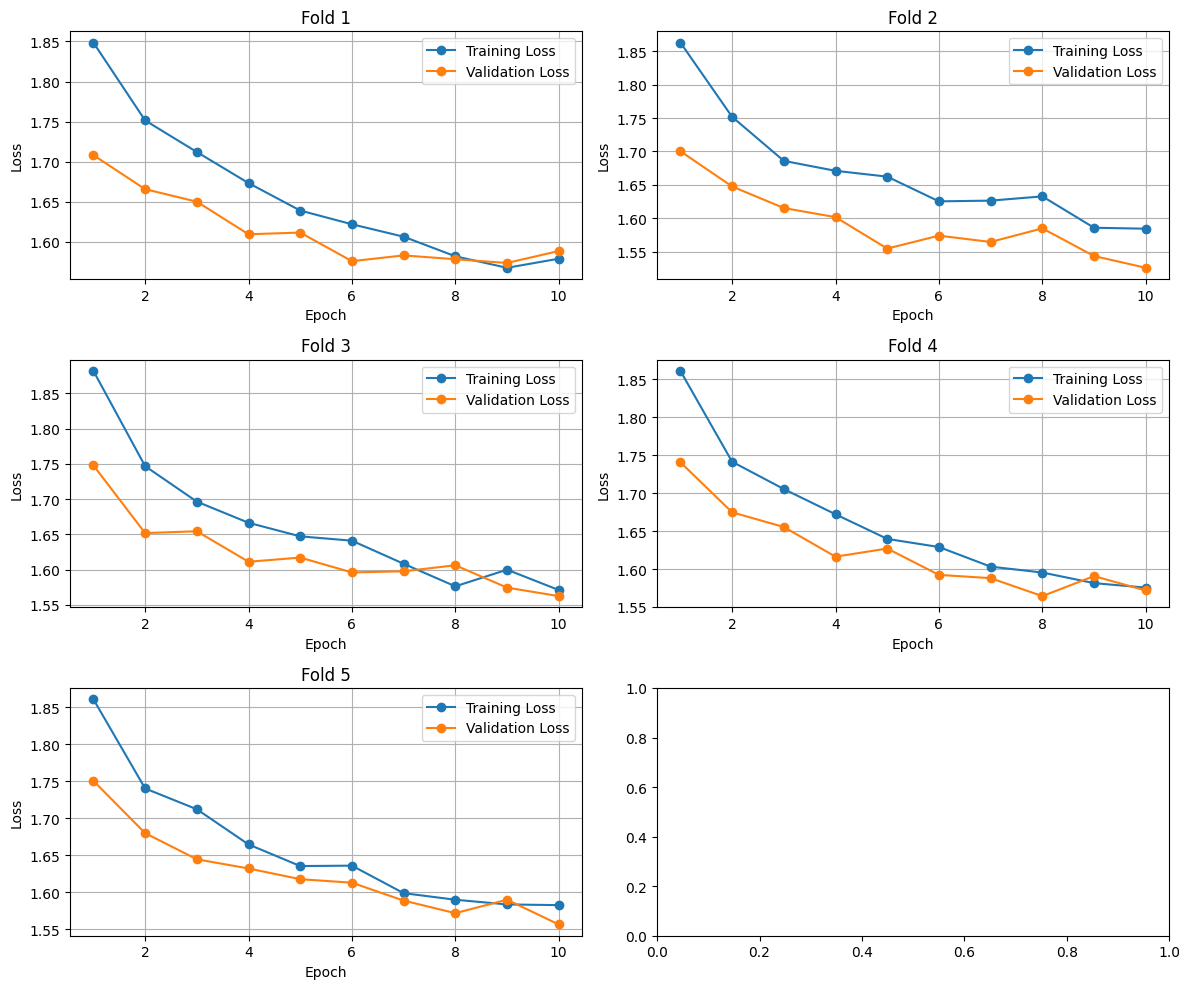

In [23]:
# Plotting the Learning Curves "Training Loss vs Validation Loss" for every fold

# Layout settings
fig, axes = plt.subplots(3, 2, figsize = (12, 10))
axes = axes.flatten()
epochs = range(1, len(h["train_loss"]) + 1)

for i, h in enumerate(histories):
    ax = axes[i]
    ax.plot(epochs, h["train_loss"], label = "Training Loss", marker = "o")
    ax.plot(epochs, h["valid_loss"], label = "Validation Loss", marker = "o")
    ax.set_title(f"Fold {i+1}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

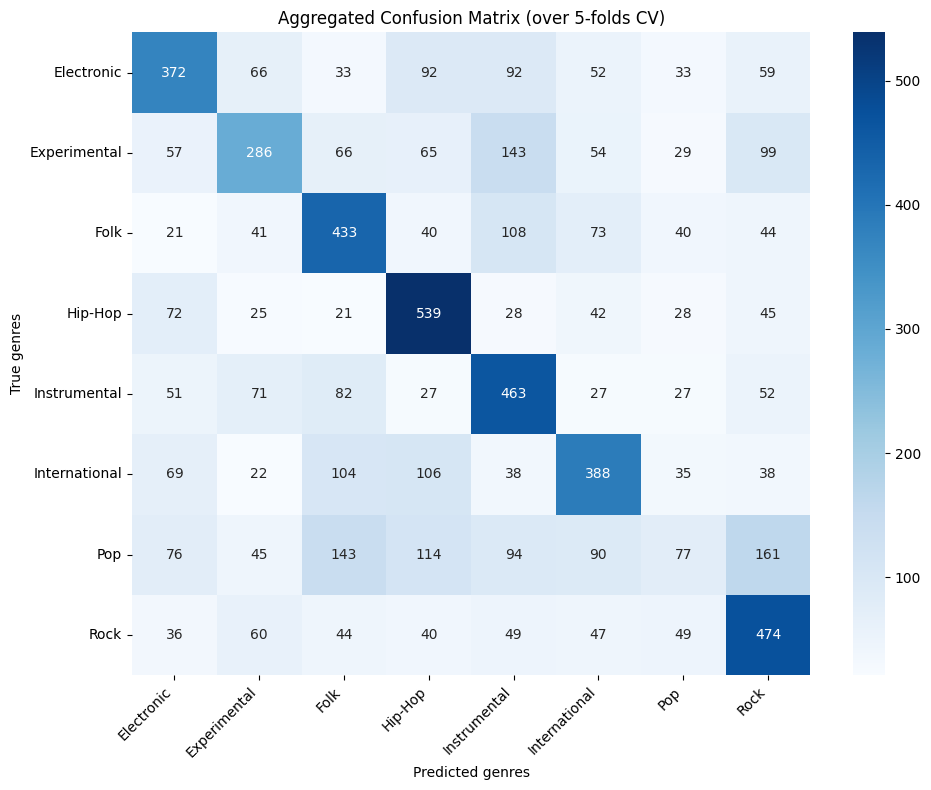

In [24]:
# Plotting the aggregated (over the 5-folds) Confusion Matrix

class_names = train_dataset.classes # retrieve the name of the categories (genres)

plt.figure(figsize = (10, 8))
sns.heatmap(global_confusion_matrix, annot = True, fmt = "d", cmap = "Blues",
            xticklabels = class_names, yticklabels = class_names)
plt.xticks(rotation = 45, ha = "right")
plt.yticks(rotation = 0)
plt.title("Aggregated Confusion Matrix (over 5-folds CV)")
plt.xlabel("Predicted genres")
plt.ylabel("True genres")
plt.tight_layout() # to avoid cutting the genres' labels
plt.show()

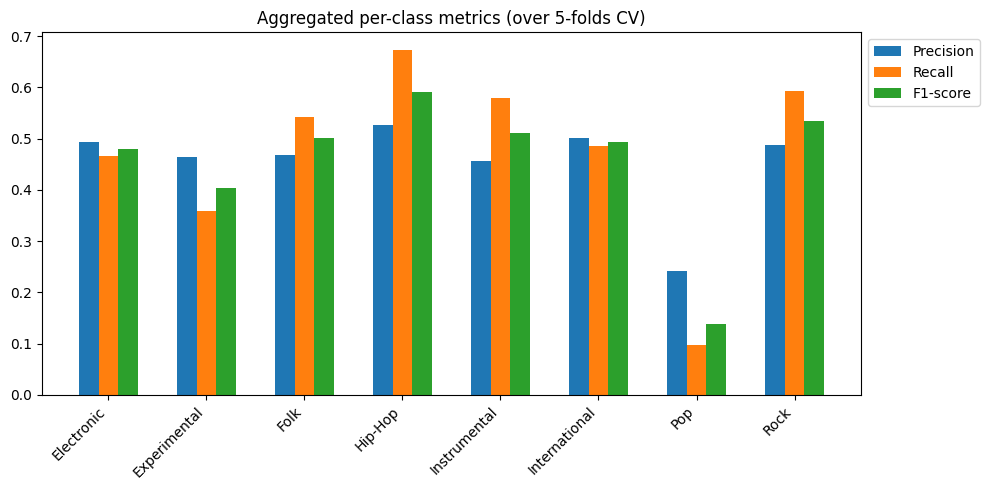

In [25]:
# Plotting the aggregated per-class metrics (precision, recall, f1-score)

# Instead of considering the value computed in every fold for these three metrics,
# the latter are computed confronting all predictions and labels (6397*5)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average = None, labels = np.arange(num_classes))

plt.figure(figsize = (10,5))
plt.bar(np.arange(num_classes) - 0.2, precision, width = 0.2, label = "Precision")
plt.bar(np.arange(num_classes), recall, width = 0.2, label = "Recall")
plt.bar(np.arange(num_classes) + 0.2, f1, width = 0.2, label = "F1-score")
plt.xticks(np.arange(num_classes), class_names, rotation = 45, ha = 'right')
plt.legend(loc = "upper left", bbox_to_anchor = (1.0, 1))
plt.title("Aggregated per-class metrics (over 5-folds CV)")
plt.tight_layout()
plt.show()

# Final model (EfficientNet-B0)

## Training

In [27]:
# After training and evaluating the model on 80% of the data through Cross-Validation, this portion of the dataset
# will be used one last time, in its entirety, to train the model (its "optimized version"). The metrics of the model
# will be then computed on the test set (the remaining 20% of the data) as final evaluation

# [Same reasoning the previous "Training" section]

num_classes = len(train_dataset.classes)
device = "cuda" if torch.cuda.is_available() else "cpu"

final_epochs = 10
all_losses = {"train_loss": [], "test_loss": []}

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 2, pin_memory = True)

model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in model.parameters():
  param.requires_grad = False

for idx, block in enumerate(model.features[4:]):
      for param in block.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing = 0.05)

base_params = [p for n, p in model.named_parameters() if 'classifier' not in n and p.requires_grad]
head_params = [p for n, p in model.named_parameters() if 'classifier' in n and p.requires_grad]
optimizer = torch.optim.AdamW([
        {'params': base_params, 'lr': 5e-5, 'weight_decay': 1e-5},
         {'params': head_params, 'lr': 5e-4, 'weight_decay': 1e-5}
        ], betas = (0.9, 0.999), eps = 1e-8)

scheduler = CosineAnnealingLR(optimizer, T_max = final_epochs)
scaler = torch.amp.GradScaler('cuda')

for epoch in range(final_epochs):

    model.train()

    train_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        if random.random() < 0.3:
          images, labels_a, labels_b, lam = specmix(images, labels, alpha = 0.25)
        else:
          labels_a, labels_b, lam = labels, labels, 1.0

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):

            outputs = model(images)
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss_epoch = train_loss / len(train_loader)
    all_losses["train_loss"].append(train_loss_epoch)

    epoch_metrics = model_metrics(model, test_loader, device, criterion, num_classes)
    all_losses["test_loss"].append(epoch_metrics["valid_loss"])

    scheduler.step()

    print(f"Epoch {epoch+1}: Training loss = {train_loss_epoch:.4f}")

print("\n✅ Final Training completed")

Epoch 1: Training loss = 1.8829
Epoch 2: Training loss = 1.7544
Epoch 3: Training loss = 1.7056
Epoch 4: Training loss = 1.6882
Epoch 5: Training loss = 1.6651
Epoch 6: Training loss = 1.6354
Epoch 7: Training loss = 1.6355
Epoch 8: Training loss = 1.6276
Epoch 9: Training loss = 1.6346
Epoch 10: Training loss = 1.6140

✅ Final Training completed


## Evaluation

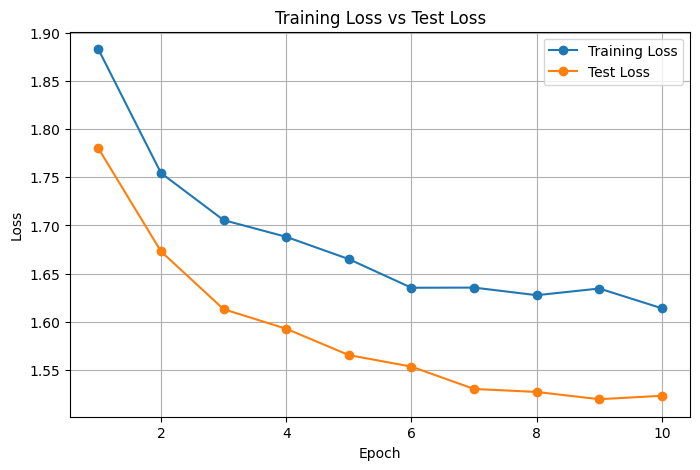

In [28]:
# Plotting the Learning Curve "Training Loss vs Test Loss" for every epoch

# Extracting the loss values
train_losses = all_losses["train_loss"]
test_losses = all_losses["test_loss"]

# Plotting the results
plt.figure(figsize = (8,5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label = "Training Loss", marker = "o")
plt.plot(epochs, test_losses, label = "Test Loss", marker = "o")
plt.title("Training Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [29]:
# Computing the final evaluation metrics

final_metrics = model_metrics(model, test_loader, device, criterion, num_classes)

print(f"Top-3 Accuracy on the Test set: {final_metrics["topk_accuracy"]:.4f}")
print(f"Precision on the Test set: {final_metrics["precision"]:.4f}")
print(f"Recall on the Test set: {final_metrics["recall"]:.4f}")
print(f"F1-score on the Test set: {final_metrics["f1-score"]:.4f}")

print(f"\n🔎 Accuracy on the Test set: {final_metrics["accuracy"]:.4f}")

Top-3 Accuracy on the Test set: 0.7963
Precision on the Test set: 0.4836
Recall on the Test set: 0.4775
F1-score on the Test set: 0.4746

🔎 Accuracy on the Test set: 0.4775
